# -- Time under coverage of a base station analysis --

In [1]:
#############################################
# Import scientific computation lib
import numpy as np
import pandas as pd

# Import I/O and data management lib
import scipy.io as sio
import csv

# Import Plotting lib
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from matplotlib.patches import RegularPolygon
from scipy.stats import norm
import seaborn as sns; sns.set()
from matplotlib.animation import FuncAnimation
import matplotlib.patches as mpatches


# Import bokeh, an interactive visualization library that affords high-performance interactivity over large datasets
from bokeh.io import show, output_notebook, push_notebook
from bokeh.plotting import figure

from bokeh.models import CategoricalColorMapper, HoverTool, ColumnDataSource, Panel
from bokeh.models.widgets import CheckboxGroup, Slider, RangeSlider, Tabs

from bokeh.layouts import column, row, WidgetBox
from bokeh.palettes import Category20_16

from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application

################################
# Import the .mat dataset and convert to pandas dataframe

# Import the .mat files
import_mat = sio.loadmat(r'C:\Users\carlo\Desktop\HLP_Project\coordinate_BS.mat')
import_traces = sio.loadmat(r'C:\Users\carlo\Desktop\HLP_Project\traces.mat')

# Convert extracted data into pandas Dataframe adding header
bs_coordinates = pd.DataFrame(import_mat['BSCoordinates'], columns=['x', 'y'])
vehicle_traces = pd.DataFrame(import_traces['traces_data'], columns=['time', 'id', 'x', 'y', 'speed', 'C', 'C+1', 'C-1', 'C-2', 'C-3'])

######################################
#Creating a dict with the position of each bs as value - not useful for the analysis

bs_dict={}

for i, row in bs_coordinates.iterrows():
    #print(i)
    bs_dict["BS-"+str(i+1)] = [row['x'], row['y']]

##################################### 
#Functions that crop the dataset between two time extremes
#maintain only the Id fully into the cropped part

def crop_df_by_time(a,t0,tf):
    
    a.sort_values(by=['time'], inplace=True)
    
    a=a.loc[(a['time']>=t0-1) & (a['time']<tf+1)]
    
    a.reset_index(inplace=True,drop=True)

    l=len(a)-1

    while(a.loc[len(a)-2, 'time'] == a.loc[len(a)-1, 'time']):
        a = a.drop(a.index[l])
        l=l-1
        
    removed_t0_minus=False
    removed_tf_plus=False
    
    l=len(a)-1
    
    if (a.loc[0, 'id'] == a.loc[1, 'id']):
        a = a[a['id'] != a.loc[0,'id']]
        removed_t0_minus=True
        
    if (a.loc[l-1, 'id'] == a.loc[l, 'id']):
        a = a[a['id'] != a.loc[l,'id']]
        removed_tf_plus=True
        
    if (not removed_t0_minus):
        a = a.drop(a.index[0])
    
    if (not removed_tf_plus):
        a = a.drop(a.index[l])
        
    return a
    
############################
#Functions that return the df with only the activity registered by a base station
    
def bs_activity(x):
    
    mask = vehicle_traces['C'].isin([x])
    bs_activity_df = vehicle_traces[mask]
    
    #avoid warning creating a copy 'a' of the df
    a=bs_activity_df.drop(['C+1', 'C-1', 'C-2', 'C-3'],axis=1)
    
    return a

###########################
#Functon that returns the vector of unique id and the vector of their respective times under coverage of a bs from t0 to tf
#The parameter wnd permit to select the percentage of the dataset to analyze, in case we want to prepare the data 
#for a ml algorithm wich require nly a part of the df for training

def time_under_bs_prediction(x,t0,tf,wnd):
    
    a = bs_activity(x)

    full_df = crop_df_by_time(a,t0,tf)
        
    t_wnd_tf=t0+int((tf-t0)*wnd)
    
    wnd_df = crop_df_by_time(a,t0,t_wnd_tf)
    
    #wnd_df.to_csv(r'C:\Users\carlo\Desktop\HLP_Project\wnd57.csv')
    
    uniq_id = np.unique(wnd_df['id'])
    
    id_time = np.zeros([len(uniq_id)])
    
    for i in range(len(uniq_id)):
        id_time[i] = (wnd_df['id'] == uniq_id[i]).sum()
    
    #print(id_time)
    
    return uniq_id, id_time

############################
#Simpler version of the previous function that return only the full vector (wnd=1) 
#of times under coverage between an intervall

def id_times(a,t0,tf):
    
    full_df = crop_df_by_time(a, t0, tf)
    uniq_id = np.unique(full_df['id'])
    id_time = np.zeros([len(uniq_id)])
    
    for i in range(len(uniq_id)):
        id_time[i] = (full_df['id'] == uniq_id[i]).sum()
        
    return id_time
   
##################################
#Function that returns the daily times under coverage of a bs divided in five day time divisions
   
def full_day_bs_coverage(x):
    
    a = bs_activity(x)    
    a.sort_values(by=['time'], inplace=True)
    a.reset_index(inplace=True,drop=True)
    
    tot_l=len(a)-1
    
    first_time = a.loc[0,'time']
    last_time =  a.loc[tot_l,'time']
    
    p1=id_times(a,first_time,20000) #first part of night from the first time registered to 20000 seconds (20000/3600 = 5.5)
    p2=id_times(a,20000,40000) # early morning
    p3=id_times(a,40000,50000) #late morning and early afternoon
    p4=id_times(a,50000,70000) # late afternoon until night
    p5=id_times(a,70000,last_time) #second part of the night until the end of the recording
    
    return p1, p2, p3, p4, p5

In [2]:
def wnd_percentage_difference(bs):

    #Comparing the activity on a sigle time interval (50000 - 70000 seconds) with different wnd percentages 20% 50% 80%

    id_out1, times_out1 = time_under_bs_prediction(bs,45000,65000,0.2)
    id_out2, times_out2 = time_under_bs_prediction(bs,45000,65000,0.5)
    id_out3, times_out3 = time_under_bs_prediction(bs,45000,65000,0.8)

    fig, ax = plt.subplots(figsize=(10,10))
    
    plt.xlabel('Time under coverage [s]')
    plt.ylabel('Normalized frequency')

    plt.title('Activity under the Bs-' + str(bs) + ' from time 50000 to 70000 [s]')


    sns.distplot(times_out1, bins=int(max(times_out1)), norm_hist=True, color="b", ax=ax)

    sns.distplot(times_out2, bins=int(max(times_out2)), norm_hist=True, color="g", ax=ax)

    sns.distplot(times_out3, bins=int(max(times_out3)), norm_hist=True, color="r", ax=ax)

    blue_patch = mpatches.Patch(color='b', label='20 % window size')
    green_patch = mpatches.Patch(color='g', label='50 % window size')
    red_patch = mpatches.Patch(color='r', label='80 % window size')

    plt.legend(handles=[blue_patch, green_patch, red_patch])

    plt.show()


In [3]:
def time_under_coverage_analysis_bs(bs):

    #BS-117
    #Extracting the data recorded during the day and creating 5 df of times under coverage 
    #in the different parts of the day

    p1, p2, p3, p4, p5 = full_day_bs_coverage(bs)

    #Concatenating the 5 parts of day dataframes in a sinle df
    b = np.concatenate((p1, p2, p3, p4, p5), axis=None)

    #Adding a column with the name of the respective part of the day
    day_parts = []

    for x in range(len(p1)):
        day_parts.append('Night (24-5)')
    for x in range(len(p2)):
        day_parts.append('Early Morning (5-11)')
    for x in range(len(p3)):
        day_parts.append('Late Morning/Early Afternoon (11-14)')
    for x in range(len(p4)):
        day_parts.append('Late Afternoon (14-20)')
    for x in range(len(p5)):
        day_parts.append('Night (20-24)')


    full_time_coverage = pd.DataFrame({'seconds': b, 
                           'part_of_day': day_parts })

    #simple list of the five string corrispondng to different day time division
    time_division = list(full_time_coverage['part_of_day'].unique())

    #five normal distributrions division - not useful for the analysis
    gaussian_division = ['dist1', 'dist2', 'dist3', 'dist4', 'dist5']

    ##########################################################################################################################

    #Dynamic histogram plot

    #Repeted import of libraries for avoiding a bokeh error (?)

    from bokeh.io import show, output_notebook, push_notebook
    from bokeh.plotting import figure

    from bokeh.models import CategoricalColorMapper, HoverTool, ColumnDataSource, Panel
    from bokeh.models.widgets import CheckboxGroup, Slider, RangeSlider, Tabs

    from bokeh.layouts import column, row, WidgetBox
    from bokeh.palettes import Category20_16

    from bokeh.application.handlers import FunctionHandler
    from bokeh.application import Application

    output_notebook()  #this function will show the plot in the notebook instead of opening an external html page 

    #A way to make interactive plots is to embed a bokeh application into jupyter.

    #The modify function embed all the function necessary to generate the dataframe, plot and eventually update the data 
    #relying on what types of data is interactively selected

    def modify_doc(doc):

        ########################################
        #The makedatest functions prepare the selected data to be plotted

        def make_dataset(time_division_list, bins_number, range_start, range_end):

            by_part = pd.DataFrame(columns=['proportion', 'left', 'right', 'number_id_for_bin', 'name', 'color'])

            # Iterate through all the carriers
            for i, part_of_day in enumerate(time_division_list):

                # Subset to the carrier
                subset = full_time_coverage[full_time_coverage['part_of_day'] == part_of_day]

                # Create a histogram with specified bins and range
                arr_hist, edges = np.histogram(subset['seconds'], 
                                               bins = int(bins_number), 
                                               range = [range_start, range_end],
                                               density = True)

                # Create a not normalized histogram. This will give us the number of cars in every bin
                arr_hist2, edges2 = np.histogram(subset['seconds'], 
                                                 bins = int(bins_number), 
                                                 range = [range_start, range_end])


                # Divide the counts by the total to get a proportion and create df
                arr_df = pd.DataFrame({'proportion': arr_hist/np.sum(arr_hist), 
                                       'left': edges[:-1], 'right': edges[1:] })

                # Assign number of vehicle fr every bin
                arr_df['number_id_for_bin'] = arr_hist2

                # Assign the carrier for labels
                arr_df['name'] = part_of_day

                # Color each carrier differently
                arr_df['color'] = Category20_16[i*2]

                # Add to the overall dataframe
                by_part = by_part.append(arr_df)

            # Sorting overall dataframe - not usefull already sorted
            #by_part = by_part.sort_values(['name', 'left'])

            return ColumnDataSource(by_part)  # The column data source function transform a dataframe or a dictionary in 
                                              # an object that can be used as source of data by the bokeh plotting functions

        ##################################à 
        #The style function simply set the style of the text in labels and title

        def style(p):
            # Title 
            p.title.align = 'center'
            p.title.text_font_size = '20pt'
            p.title.text_font = 'serif'

            # Axis titles
            p.xaxis.axis_label_text_font_size = '14pt'
            p.xaxis.axis_label_text_font_style = 'bold'
            p.yaxis.axis_label_text_font_size = '14pt'
            p.yaxis.axis_label_text_font_style = 'bold'

            # Tick labels
            p.xaxis.major_label_text_font_size = '12pt'
            p.yaxis.major_label_text_font_size = '12pt'

            return p

        ############################ 
        #The make plot function plt the histogram and generate the hoovers (info that compare when an object is highlighted)

        def make_plot(src1):
            # Blank plot with correct labels
            p = figure(plot_width = 700, plot_height = 700, 
                      title = 'Daily activity time under the Bs-' + str(bs),
                      x_axis_label = 'Time under coverage [s]', y_axis_label = 'Frequency')

            # Quad glyphs to create a histogram
            p.quad(source = src1, bottom = 0, top = 'proportion', left = 'left', right = 'right',
                   color = 'color', name = 'histo', fill_alpha = 0.7, hover_fill_color = 'color', legend = 'name',
                   hover_fill_alpha = 1.0, line_color = 'black')

            # Hover tool with vline mode
            hover1 = HoverTool(names=['histo'], tooltips=[('Sojourn time', '@left seconds'),
                              ('Number of vehicles', '@number_id_for_bin')],
                              mode='vline')

            p.add_tools(hover1)

            p.legend.click_policy = 'hide'

            #Adding hovers
            #p.add_tools(hover1)
            #p.add_tools(hover2)

            # Styling
            p = style(p)
            return p

        ############## 
        #The update function use the interactive input of the bokeh 'CheckboxGroup' object and 
        #update the 'making' of the dataset that will be plotted

        def update(attr, old, new):

            # Get the list of carriers for the graph
            period_to_plot = [period_selection.labels[i] for i in 
                                period_selection.active]

            # Make a new dataset based on the selected carriers and the 
            # make_dataset function defined earlier
            new_src = make_dataset(period_to_plot, int(max(b)), 0, int(max(b)))

            # Update the source used in the quad glpyhs
            src.data.update(new_src.data)

            #src = new_src
            #src2 = new_src2

        #######

        period_selection = CheckboxGroup(labels=time_division, active = [0, 1, 2, 3, 4]) #The object that permits the user to
        period_selection.on_change('active', update)                                     #select interactively the data

        controls = WidgetBox(period_selection)

        initial_time = [period_selection.labels[i] for i in period_selection.active]

        src = make_dataset(initial_time, int(max(b)), 0, int(max(b)))

        p = make_plot(src)

        layout = row(controls, p)
        doc.add_root(layout)



    # Set up an application
    handler = FunctionHandler(modify_doc)
    app = Application(handler)

    show(app)

    #######################################################################################################################

    #Static interactive bokeh plot with the addition of the normal distribution for each part of the day

    def make_dataset_static_plot(time_division_list, bins_number, range_start, range_end):

        by_part = pd.DataFrame(columns=['proportion', 'left', 'right', 'number_id_for_bin', 'name', 'color'])

        # Iterate through all the carriers
        for i, part_of_day in enumerate(time_division_list):

            # Subset to the carrier
            subset = full_time_coverage[full_time_coverage['part_of_day'] == part_of_day]

            # Create a histogram with specified bins and range
            arr_hist, edges = np.histogram(subset['seconds'], 
                                           bins = int(bins_number), 
                                           range = [range_start, range_end],
                                           density = True)

            arr_hist2, edges2 = np.histogram(subset['seconds'], 
                                             bins = int(bins_number), 
                                             range = [range_start, range_end])


            # Divide the counts by the total to get a proportion and create df
            arr_df = pd.DataFrame({'proportion': arr_hist/np.sum(arr_hist), 
                                   'left': edges[:-1], 'right': edges[1:] })

            # Assign number of vehicle fr every bin
            arr_df['number_id_for_bin'] = arr_hist2

            # Assign the carrier for labels
            arr_df['name'] = part_of_day

            # Color each carrier differently
            arr_df['color'] = Category20_16[i*2]

            # Add to the overall dataframe
            by_part = by_part.append(arr_df)

        # Overall dataframe
        #by_part = by_part.sort_values(['name', 'left'])

        return by_part

    ########

    def make_dataset2_static_plot(time_division_list, range_num):

        #by_part2 = pd.DataFrame(columns=['x', 'pdf', 'sigma', 'mu', 'color'])

        by_part2 = []

        # Iterate through all the carriers
        for i, part_of_day in enumerate(time_division_list):

            # Subset to the carrier
            subset = full_time_coverage[full_time_coverage['part_of_day'] == part_of_day]

            b = np.asarray(subset['seconds'])

            x = np.linspace(0, int(range_num), 1000)
            sigma = np.std(b)
            mu = np.mean(b)

            sigma1 = np.full(1000, sigma)
            mu1 = np.full(1000, mu)

            pdf = 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2 / (2*sigma**2))

            normal_dist = pd.DataFrame({'x': x, 'pdf':pdf, 'sigma': sigma1, 'mu': mu1 })

            normal_dist['color'] = Category20_16[i*2]

            # Add to the overall dataframe
            by_part2.append(normal_dist)    

        return by_part2

    #######


    def style_static_plot(p):
            # Title 
            p.title.align = 'center'
            p.title.text_font_size = '20pt'
            p.title.text_font = 'serif'

            # Axis titles
            p.xaxis.axis_label_text_font_size = '14pt'
            p.xaxis.axis_label_text_font_style = 'bold'
            p.yaxis.axis_label_text_font_size = '14pt'
            p.yaxis.axis_label_text_font_style = 'bold'

            # Tick labels
            p.xaxis.major_label_text_font_size = '12pt'
            p.yaxis.major_label_text_font_size = '12pt'

            return p

    def make_plot_all_static(src1, src2):
            # Blank plot with correct labels
            p = figure(plot_width = 700, plot_height = 700, 
                      title = 'Daily activity time under the Bs-' + str(bs),
                      x_axis_label = 'Time under coverage [s]', y_axis_label = 'Frequency')

            # Quad glyphs to create a histogram
            p.quad(source = src1, bottom = 0, top = 'proportion', left = 'left', right = 'right',
                   color = 'color', name = 'histo', fill_alpha = 0.7, hover_fill_color = 'color', legend = 'name',
                   hover_fill_alpha = 1.0, line_color = 'black')

            # Hover tool with vline mode
            hover1 = HoverTool(names=['histo'], tooltips=[('Sojourn time', '@left seconds'),
                              ('Number of vehicles', '@number_id_for_bin')],
                              mode='vline')

            p.add_tools(hover1)

            i=0

            for x in by_part2:

                src=ColumnDataSource(x)

                #Line glyphs to create the normal distribution
                p.line(source = src, x='x', y='pdf', name = 'norm', line_color= Category20_16[i*2], line_width=3, alpha=0.7,
                      hover_line_color=Category20_16[i*2])

                hover2 = HoverTool(names=['norm'], tooltips = [('Mean', '@mu'),('Std', '@sigma')])

                p.add_tools(hover2)

                i = i+1

            # Styling
            p = style_static_plot(p)

            return p

    by_part = make_dataset_static_plot(time_division, int(max(b)), 0, int(max(b)))
    by_part2 = make_dataset2_static_plot(time_division, int(max(b)))

    #######

    output_notebook()
    static_all = make_plot_all_static(ColumnDataSource(by_part),by_part2)
    show(static_all)


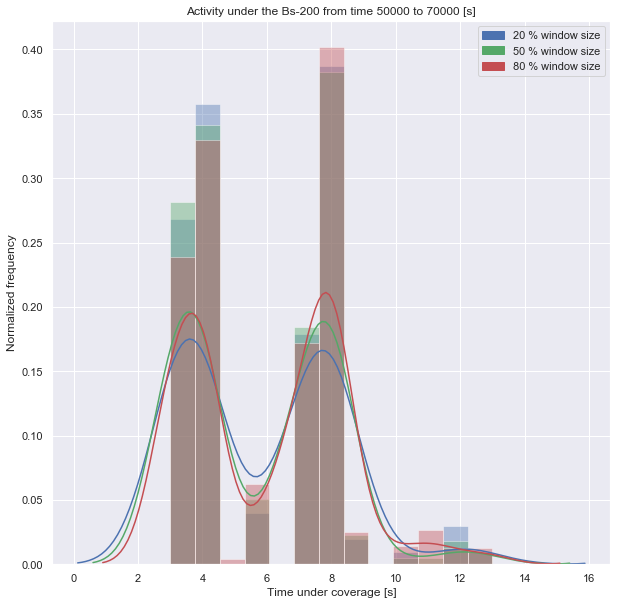

In [4]:
wnd_percentage_difference(200)

In [5]:
time_under_coverage_analysis_bs(200)

Loading BokehJS ...

Loading BokehJS ...

In [6]:
time_under_coverage_analysis_bs(115)

Loading BokehJS ...

Loading BokehJS ...